# テーブル作成の続き & 季節性の確認

## パーツのワランティ件数の生産台数に対する割合(累積ベース, 時系列)

In [1]:
from sqlalchemy import create_engine
from pathlib import Path

PATH_DB = Path("../data/interim/suzuki_phase2_db.sqlite3")
engine = create_engine(f"sqlite:///{PATH_DB.as_posix()}")

In [2]:
import pandas as pd

pd.read_sql("select * from warranty limit 5;", engine)

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,...,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRAEID200608B000001,118700,118700,1,B,1,200608,5725,AE,0607003,...,0.0,296.0,1753.0,None,0,0.0,12,3,None,17-06-20 14:01:16.950054000
1,WRAEID200608B000002,118700,118700,1,B,1,200608,5725,AE,0607006,...,3528.0,0.0,5174.0,None,0,0.0,12,3,None,17-06-20 14:01:16.952369000
2,WRAEID200608B000003,118700,118700,1,B,1,200608,5725,AE,0607001,...,3528.0,0.0,5174.0,None,0,0.0,13,5,None,17-06-20 14:01:16.954219000
3,WRAEID200608B000004,118700,118700,1,B,1,200608,5725,AE,0607002,...,3528.0,0.0,5174.0,None,0,0.0,13,3,None,17-06-20 14:01:16.956251000
4,WRAEID200608B000005,118700,118700,1,B,1,200608,5725,AE,0607004,...,0.0,1714.0,8606.0,None,0,0.0,12,4,None,17-06-20 14:01:16.957878000


In [239]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 月毎のワランティ数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産され、国内に出荷された四輪、二輪に限定。

df_warranty_model_part_num_monthly = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,substr(W_FAILURE_DATE, 1, 6) as month
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = "100100"
        and W_PROD_DIV = "B"
        and W_DMEX_DIV = "0"
    group by
        model_cd, part_cd, month;
    """
    , engine)

CPU times: user 21.6 s, sys: 5.81 s, total: 27.4 s
Wall time: 31.2 s


In [4]:
PATH_INTERIM_DATA = Path("../data/interim/")

In [ ]:
df_warranty_model_part_num_monthly.to_feather(PATH_INTERIM_DATA/"df_warranty_model_part_num_monthly.feather")

In [5]:
df_warranty_model_part_num_monthly = pd.read_feather(PATH_INTERIM_DATA/"df_warranty_model_part_num_monthly.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [242]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 経過月毎のワランティ数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産され、国内に出荷された四輪、二輪に限定。

df_warranty_model_part_num_month_passed = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,W_SALES_TO_FAILURE as month_passed
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
    group by
        model_cd, part_cd, month_passed;
    """
    , engine)

CPU times: user 19.1 s, sys: 3.97 s, total: 23 s
Wall time: 25.2 s


In [243]:
df_warranty_model_part_num_month_passed.to_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_month_passed.feather")

In [6]:
df_warranty_model_part_num_month_passed = pd.read_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_month_passed.feather")

In [145]:
%%time

# 通期(データ全体)で見た場合の、モデル毎の月毎の生産数を確認
# モデルコードを上3(二輪は4桁)に絞って集計
# 国内で生産された四輪、二輪に限定。

df_fcok_model_num_monthly = pd.read_sql(
    """
    select
        case 
            when V_PROD_DIV = "A" then substr(V_PROD_MODEL_CD, 1, 4)
            when V_PROD_DIV = "B" then substr(V_PROD_MODEL_CD, 1, 3)
        else V_PROD_MODEL_CD
        end as PROD_CD
        ,substr(V_FCOK, 1,6) as MONTH
        ,count(*) as N 
    from
        tbhaa_all
    where
        V_BASE_CD = "100100"
        and V_PROD_DIV in ("A", "B")
    group by
        PROD_CD, MONTH;
    """
    , engine)

CPU times: user 36.4 s, sys: 22 s, total: 58.4 s
Wall time: 2min 5s


In [7]:
df_fcok_model_num_monthly = pd.read_csv(PATH_INTERIM_DATA/"df_fcok_model_num_monthly.csv",
                                  low_memory=False, index_col=0)
df_fcok_model_num_monthly["MONTH"] = pd.to_datetime(df_fcok_model_num_monthly["MONTH"].astype(str) + "01")

In [8]:
parts_top = (df_warranty_model_part_num_monthly
             .fillna("!Unknown")
             .groupby("part_cd")["n"]
             .sum()
             .sort_values(ascending=False))

In [247]:
parts_top.head()

part_cd
27610-76G    340055
95411-82K    107101
14200-588    104781
95410-82K     85231
85104-82K     83442
Name: n, dtype: int64

In [9]:
# パーツコードマスタを作成。どの主原因品番がどのモデルに含まれているのかの読み替え表を作成

df_part_model_master = (df_warranty_model_part_num_monthly[["part_cd", "model_cd"]]
                       .dropna()
                       .drop_duplicates())

In [10]:
from datetime import datetime

d = (pd.date_range(datetime(1994,4,1), datetime(2019, 4, 1), freq="MS")
     .to_frame(name="month"))

In [11]:
df_warranty_part_num_monthly = (df_warranty_model_part_num_monthly
                                .fillna("!Unknown")
                                .groupby(["part_cd", "month"])["n"]
                                .sum()
                                .sort_values()
                                .reset_index())
df_warranty_part_num_monthly["month"] = pd.to_datetime(df_warranty_part_num_monthly.month
                                                      .astype(str) + "01")

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
df_fcok_model_num_running_monthly = (df_fcok_model_num_monthly
                                     .copy()
                                     .sort_values(by=["PROD_CD", "MONTH"])
                                     .fillna("!Unknown"))

df_fcok_model_num_running_monthly["running"] = (df_fcok_model_num_running_monthly
                                                .groupby("PROD_CD")["N"]
                                                .transform(lambda x: x.cumsum()))

In [14]:
df_warranty_model_part_num_monthly.month.min()

'199610'

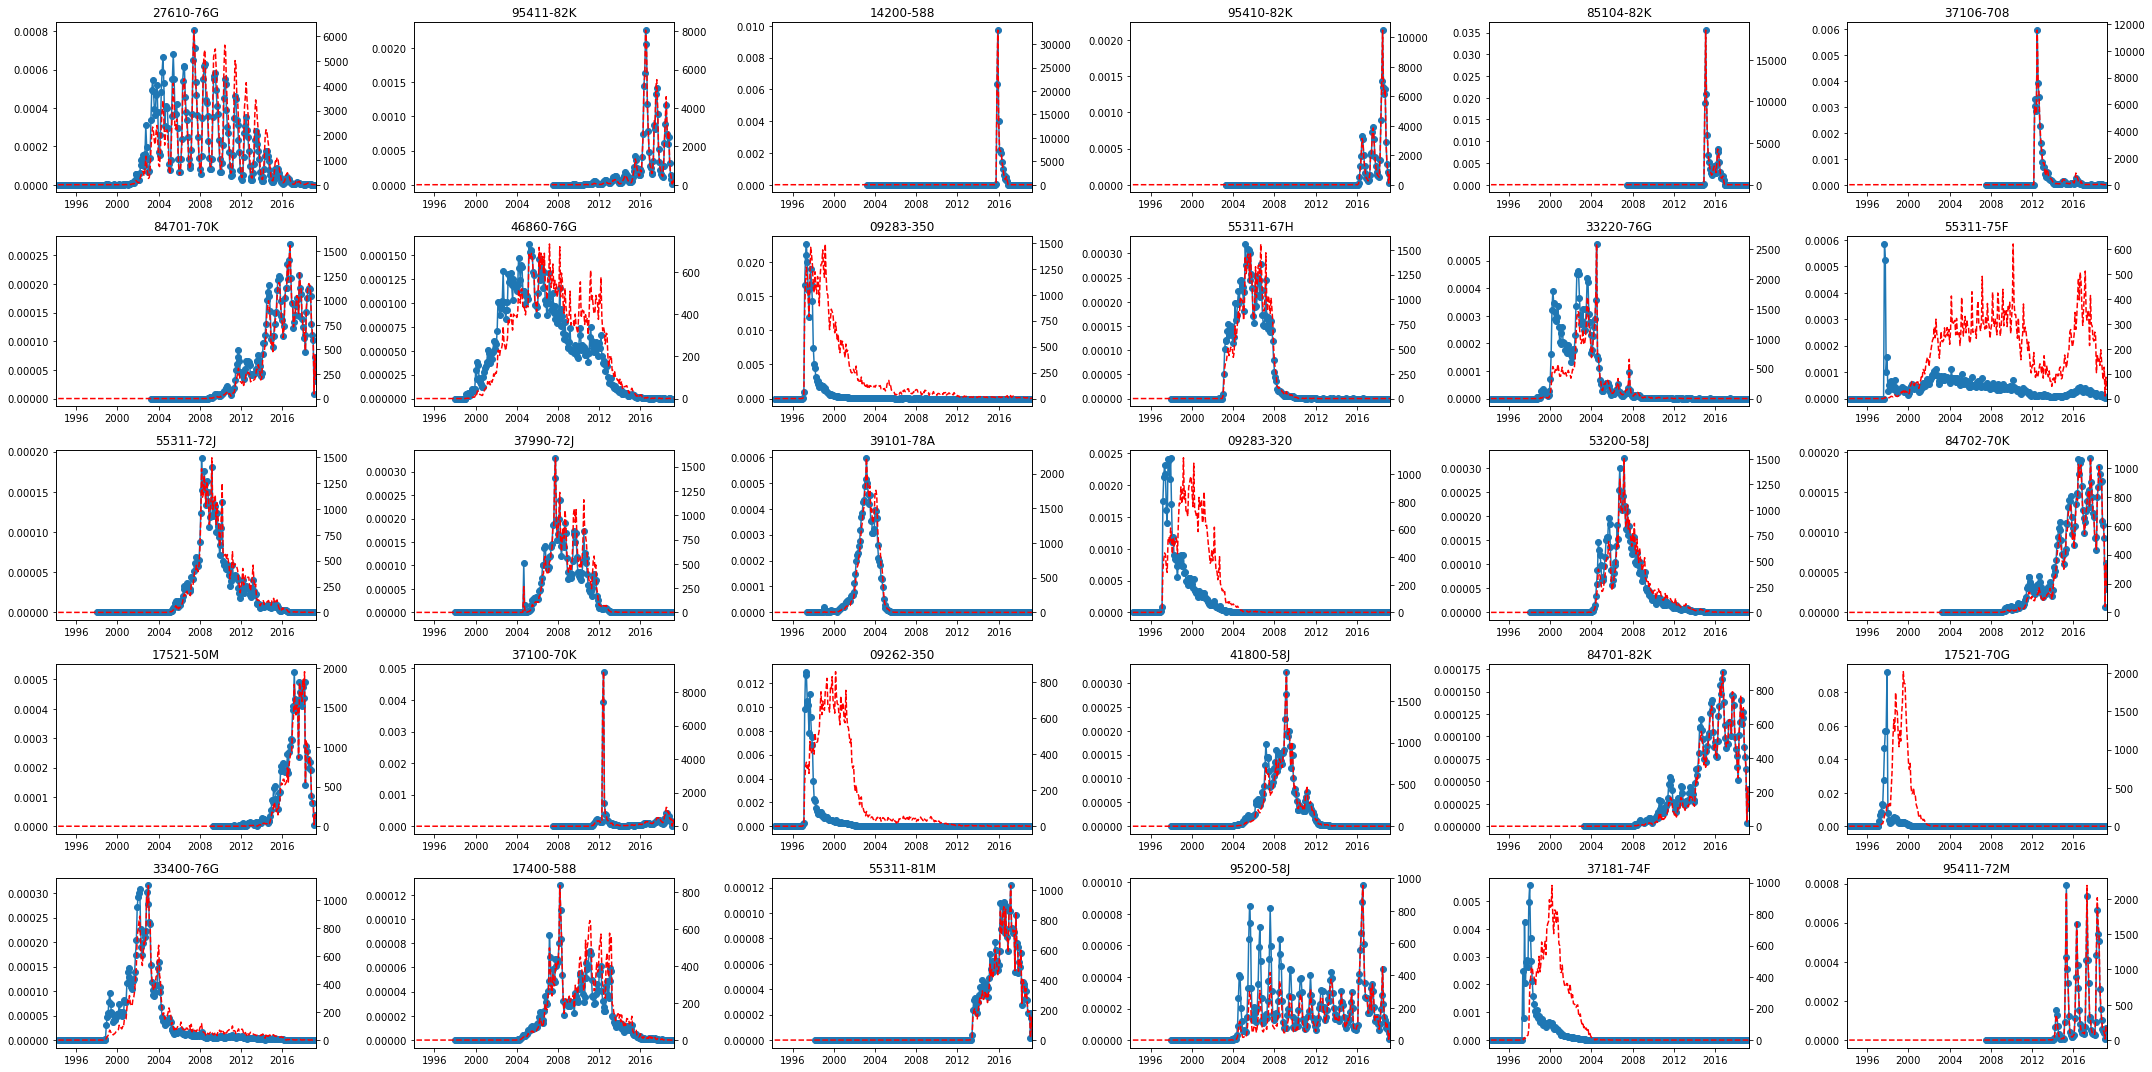

In [36]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:30]):
    ax = fig.add_subplot(5, 6, i+1)
    model_having_parts = df_part_model_master.loc[df_part_model_master.part_cd == p, "model_cd"].values
    
    # get number of produced model which has specified parts
    fcok_model_having_parts = (df_fcok_model_num_monthly
                               .loc[df_fcok_model_num_monthly.PROD_CD.isin(model_having_parts)]
                               .groupby("MONTH")["N"]
                               .sum()
                               .cumsum()
                               .reset_index()
                               .rename(columns={"MONTH":"month"}))
    tmp_total_running = (d.merge(fcok_model_having_parts, on="month", how="left")
                         .fillna(method="ffill")
                         .set_index("month"))
    tmp_warranty = df_warranty_part_num_monthly.loc[df_warranty_part_num_monthly.part_cd == p,
                                                     ["month", "n"]]
    
    tmp_warranty_m = d.merge(tmp_warranty, on="month", how="left").fillna(0).set_index("month")
    tmp_warranty_m_running = tmp_warranty_m.cumsum()
    tmp = tmp_warranty_m["n"] / tmp_total_running["N"]
    ax.plot(tmp.index, tmp.values, "o-", label="failure ratio")
    plt.title(p)
    # ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(datetime(1996,10,1), datetime(2019,4,1))
    if tmp.max() > 1: ax.set_ylim(0, 0.3) # 極端に大きい値は表示しない
    
    ax2 = ax.twinx()
    ax2.plot(tmp_warranty_m.index, tmp_warranty_m.values, "--", color="red",
           label="cumsum #warranty")
    ax2.set_xlim(datetime(1994,1,1), datetime(2019,4,1))

    # ax3 = ax.twinx()
    # ax3.plot(tmp_total_running.index, tmp_total_running.N, "--", color="green",
    #         label="cumsum #model")
    # ax3.set_xlim(datetime(2000,1,1), datetime(2019,4,1))
    
plt.tight_layout()
plt.show()

ValueError: num must be 1 <= num <= 20, not 21

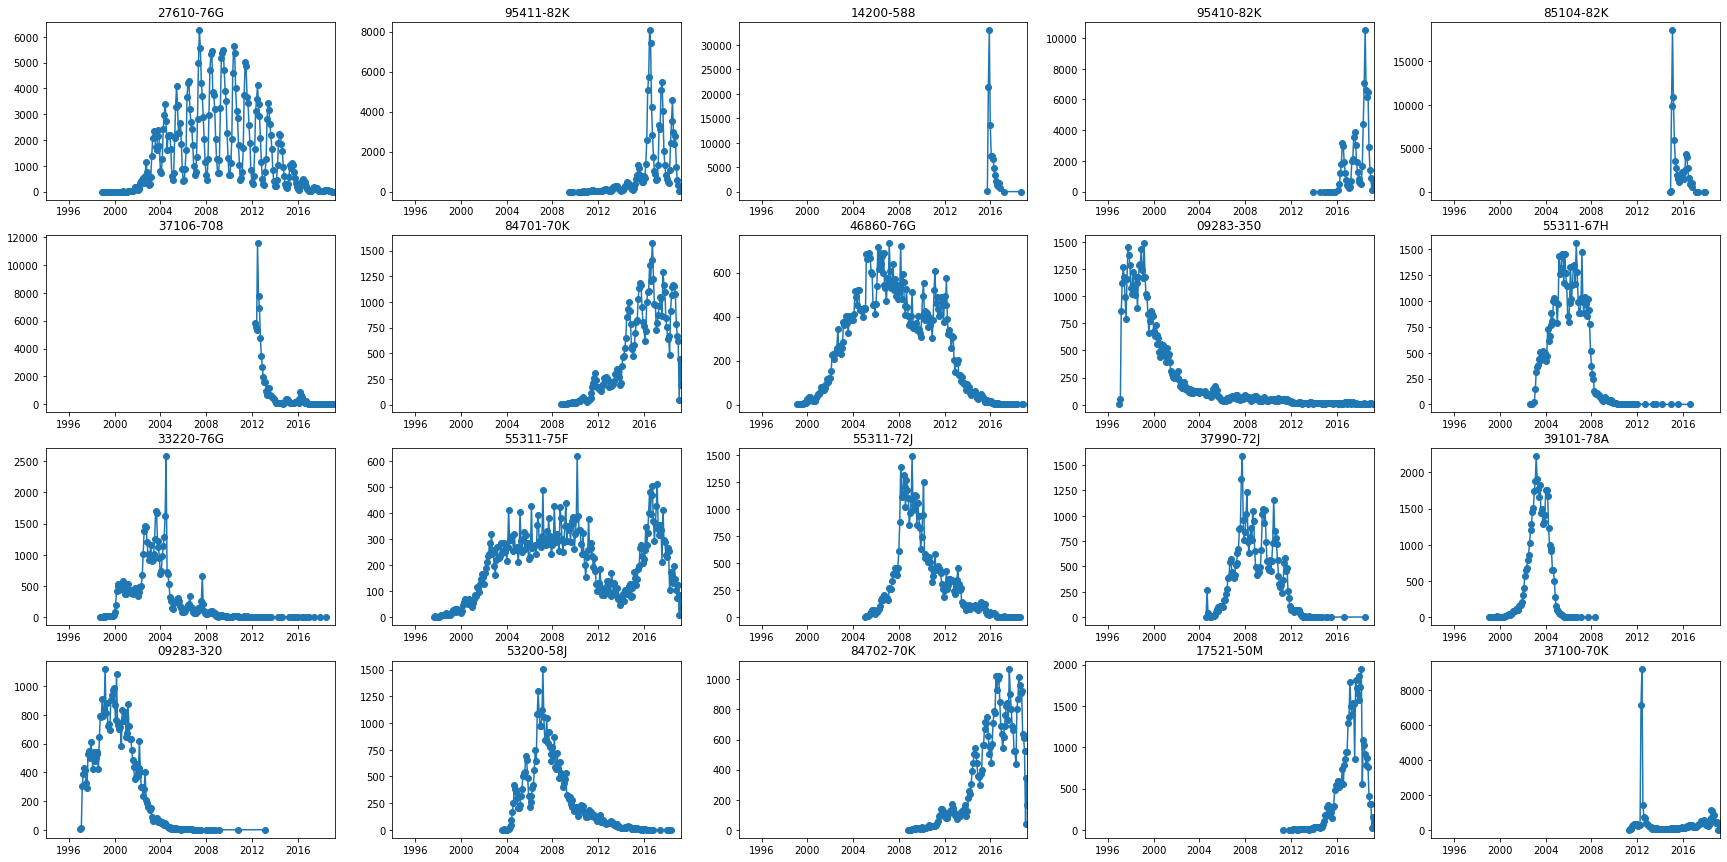

In [17]:
tmp = df_warranty_part_num_monthly.copy()
tmp = tmp.set_index("month")

plt.figure(figsize=(30,15))
for i, m in enumerate(parts_top.index[:42]):
    plt.subplot(4,5,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"].sort_index()
    plt.plot(val.index, val, "o-")
    plt.title(m)
    plt.xlim(datetime(1994,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

In [ ]:
selected_td = ["27610-76G", "37950-58J", "95411-82K", "09283-350", "33920-77F",
               "33220-76G", "55311-75F", "55311-72J", "53200-58J", "84702-70K"]

selected_sz = ["95200-58J", "09262-350", "37990-72J", "46860-76G", "17400-588"]

In [ ]:
tmp = df_warranty_part_num_monthly.copy()
tmp = tmp.set_index("month")

plt.figure(figsize=(20,15))
for i, m in enumerate(selected_td + selected_sz):
    plt.subplot(4,4,i+1)
    val = tmp.loc[tmp.part_cd == m, "n"].sort_index()
    plt.plot(val.index, val, "o-")
    plt.title(m, fontsize=20)
    plt.xlim(datetime(1994,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

徐々に上昇していき、一定の頻度で沈静化する。

## パーツのワランティ件数の生産台数に対する割合(累積ベース, 経過月)

In [272]:
df_fcok_model_num_monthly.head()

,PROD_CD,MONTH,N
0,NaN,2001-05-01,9
1,NaN,2001-06-01,108
2,NaN,2001-07-01,44
3,NaN,2001-08-01,42
4,NaN,2001-09-01,91


In [18]:
def month_passed(series, baseyear, basemonth):
    return 12 * (baseyear - series.dt.year) + (basemonth - series.dt.month)

df_fcok_model_num_month_passed = df_fcok_model_num_monthly.copy()

# 最終時点を2019/4/1とする
df_fcok_model_num_month_passed["month_passed"] = month_passed(df_fcok_model_num_month_passed.MONTH,
                                              2019, 4)

In [19]:
dp = pd.DataFrame({"month_passed":list(range(299))})

In [20]:
df_warranty_model_part_num_month_passed.head()

,model_cd,part_cd,month_passed,n
0,None,*0000-000,67,1
1,None,*1110-CT5,29,1
2,None,*1110-CT5,47,1
3,None,*1110-DC5,49,1
4,None,*1110-MA6,17,1


In [21]:
df_warranty_part_num_month_passed = (df_warranty_model_part_num_month_passed
                                     .groupby(["part_cd","month_passed"])["n"]
                                     .sum()
                                     .reset_index())

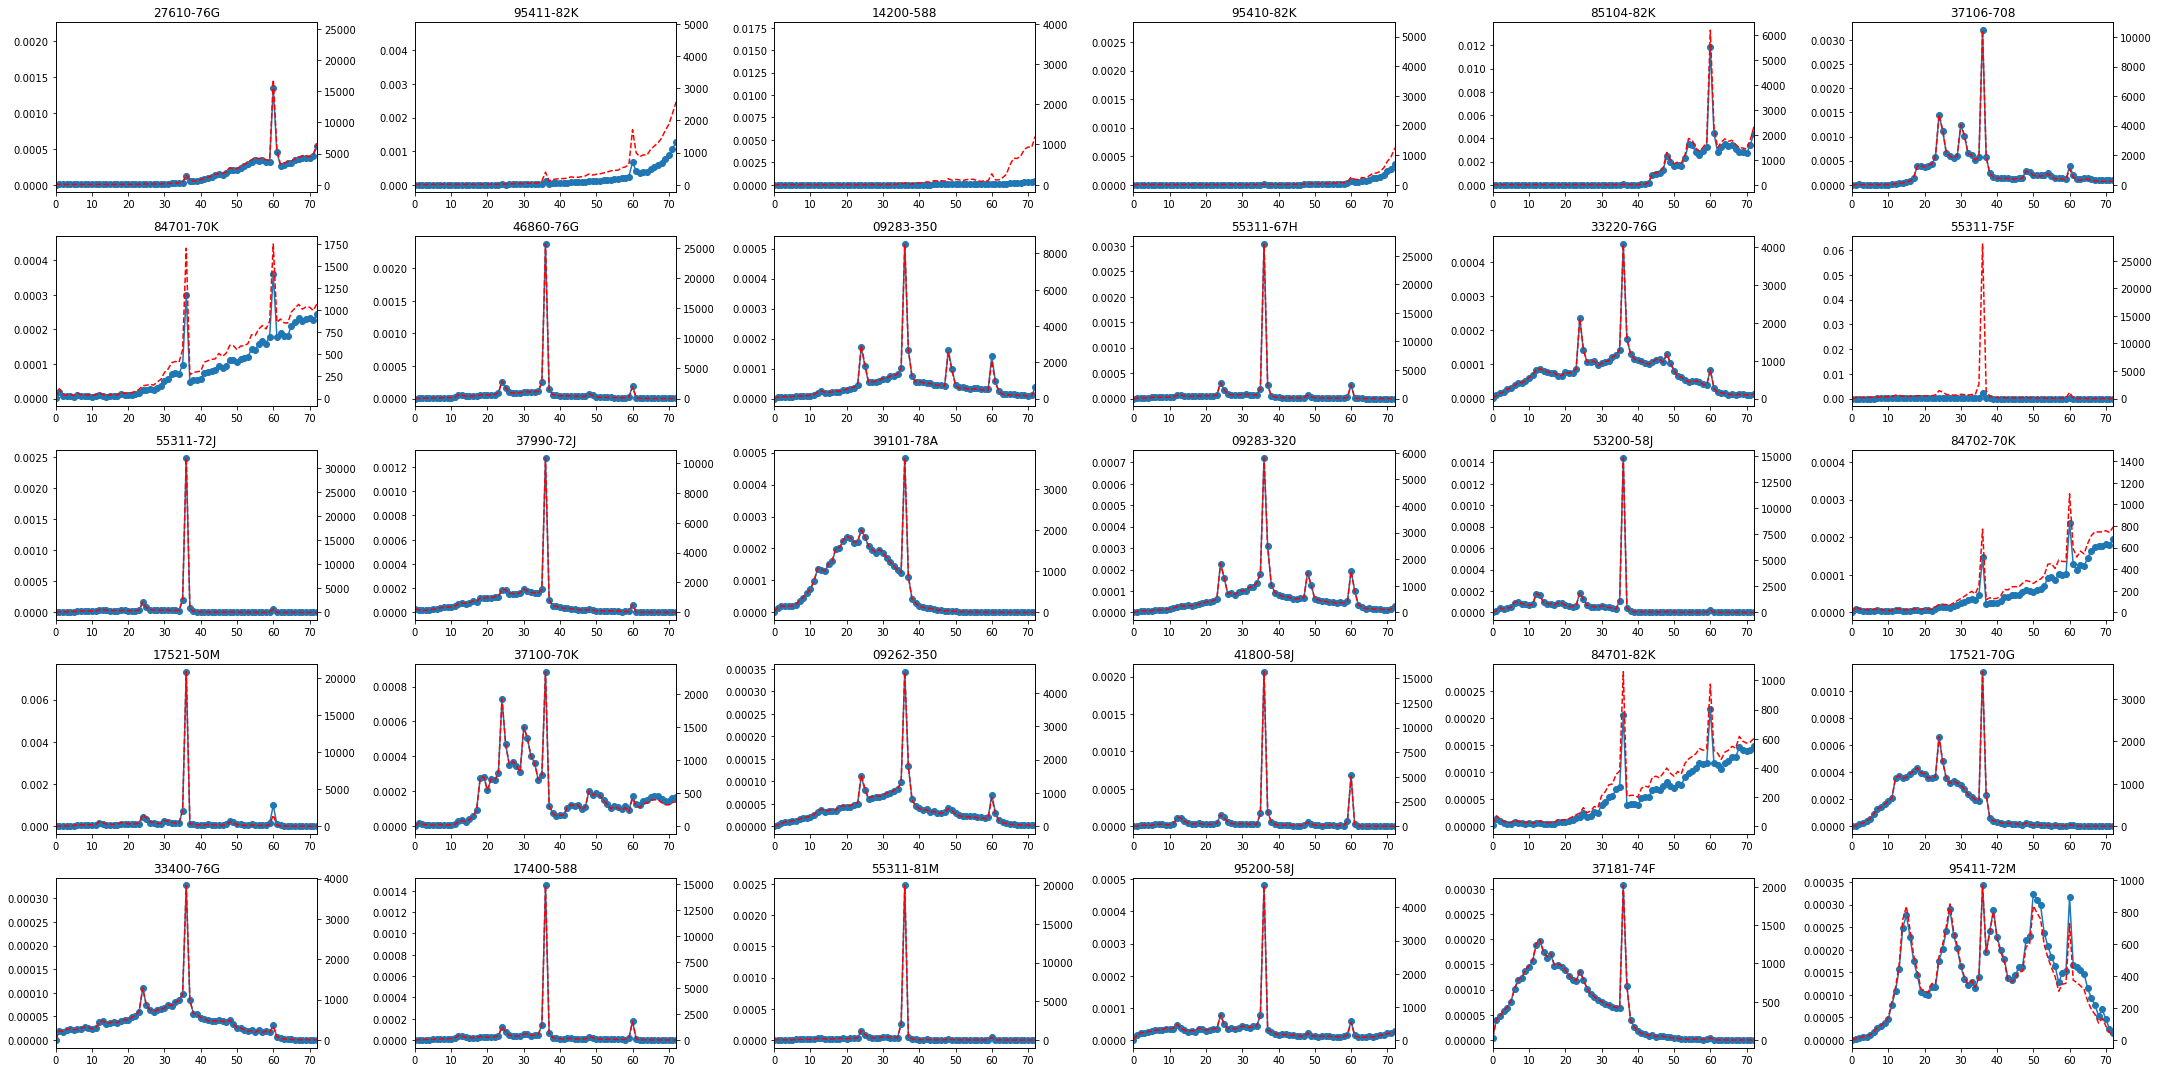

In [22]:
fig = plt.figure(figsize=(30,15))

for i, p in enumerate(parts_top.index[:30]):
    ax = fig.add_subplot(5, 6, i+1)
    model_having_parts = df_part_model_master.loc[df_part_model_master.part_cd == p, "model_cd"].values
    
    # get number of produced model which has specified parts
    fcok_model_having_parts = (df_fcok_model_num_month_passed
                               .loc[df_fcok_model_num_month_passed.PROD_CD.isin(model_having_parts)]
                               .groupby("month_passed")["N"]
                               .sum()
                               .sort_index(ascending=False)
                               .cumsum()
                               .reset_index())
    tmp_total_running = (dp.merge(fcok_model_having_parts, on="month_passed", how="left")
                         .fillna(method="bfill")
                         .set_index("month_passed"))
    tmp_warranty = df_warranty_part_num_month_passed.loc[df_warranty_part_num_month_passed.part_cd == p,
                                                     ["month_passed", "n"]]
    
    tmp_warranty_m = dp.merge(tmp_warranty, on="month_passed", how="left").fillna(0).set_index("month_passed")
    tmp_warranty_m_running = (tmp_warranty_m.sort_index(ascending=False)
                              .cumsum())
    tmp = tmp_warranty_m["n"] / tmp_total_running["N"]
    ax.plot(tmp.index, tmp.values, "o-", label="failure ratio")
    plt.title(p)
    # ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(0, 72)
    # if tmp.max() > 1: ax.set_ylim(0, 0.3) # 極端に大きい値は表示しない
    
    ax2 = ax.twinx()
    ax2.plot(tmp_warranty_m.index, tmp_warranty_m.values, "--", color="red",
           label="cumsum #warranty")
    ax2.set_xlim(0, 72)

    # ax3 = ax.twinx()
    # ax3.plot(tmp_total_running.index, tmp_total_running.N, "--", color="green",
    #         label="cumsum #model")
    # ax3.set_xlim(0, 72)
    
plt.tight_layout()
plt.show()

## (略)パーツのワランティ件数の生産台数に対する割合(生産月ごと)

### (略)パーツのワランティ件数(生産月ごと)

## (略)FTIRとワランティ, 生産台数のオーバーラップ

## フーリエ変換(周期の検出)

In [ ]:
# 宿題: fcok
# 

# その他: kaggle

In [147]:
fft_tmp = np.fft.fft(tmp_v)

In [151]:
n = len(fft_tmp)
n

301

In [157]:
abs(fft_tmp)

array([3.40055000e+05, 2.35598530e+05, 5.67031984e+04, 1.74879765e+04,
       1.14822421e+04, 2.07856298e+04, 1.25382402e+04, 1.20102501e+04,
       1.00391637e+04, 7.26003488e+03, 3.97473796e+03, 4.32009942e+03,
       7.72653132e+03, 8.80801165e+03, 6.61055975e+03, 3.29423458e+03,
       3.38291878e+03, 2.90452628e+03, 4.27571277e+03, 2.16849988e+03,
       3.05950149e+03, 2.85599983e+03, 9.62914065e+02, 3.03770396e+04,
       9.38835320e+04, 1.31251580e+05, 9.63189964e+04, 2.95108379e+04,
       7.12540659e+03, 8.16979496e+03, 4.55049462e+03, 2.29248995e+03,
       4.60680976e+03, 5.15379326e+03, 2.12287564e+03, 1.45838228e+03,
       2.79138532e+03, 1.20698022e+03, 1.92563081e+03, 1.79329783e+03,
       1.31712062e+03, 1.69333238e+03, 3.27267210e+03, 2.88969834e+03,
       2.19864074e+03, 6.99135996e+03, 9.09970277e+03, 6.65699499e+03,
       1.10683107e+04, 3.06996601e+04, 3.66892586e+04, 2.28390704e+04,
       5.31726562e+03, 4.38608318e+03, 2.88022209e+03, 2.74528025e+03,
      

In [156]:
fft_tmp

array([ 3.40055000e+05+0.00000000e+00j, -2.02504656e+05+1.20409850e+05j,
        3.24540431e+04-4.64971805e+04j,  8.53600951e+02-1.74671316e+04j,
       -1.09343195e+04+3.50464545e+03j,  1.90076288e+04+8.41144777e+03j,
       -7.03481602e+03-1.03787683e+04j, -4.58558411e+03+1.11003840e+04j,
        7.62648166e+03-6.52852097e+03j, -6.84563007e+03+2.41773766e+03j,
        3.47717678e+03-1.92556057e+03j,  1.00986318e+03+4.20040895e+03j,
       -5.14243998e+03-5.76667991e+03j,  6.38067261e+03+6.07190960e+03j,
       -4.81403230e+03-4.53040763e+03j,  7.02700793e+02+3.21841468e+03j,
        8.57387053e+02-3.27246496e+03j,  1.73190138e+03+2.33169263e+03j,
       -4.17915669e+03+9.03531432e+02j,  1.88925163e+03-1.06448111e+03j,
       -1.57404996e+03-2.62353123e+03j,  2.83728765e+03-3.26395152e+02j,
       -7.11594571e+02+6.48719249e+02j,  3.00779305e+04+4.25236720e+03j,
       -7.88712063e+04+5.09259305e+04j,  3.79255615e+04-1.25652811e+05j,
        3.56310395e+04+8.94861894e+04j, -2.42309004

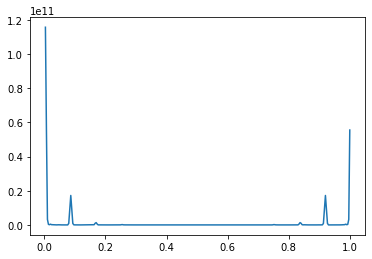

In [155]:
plt.plot(np.arange(1,301 + 1) * 1/ n ,np.abs(fft_tmp)**2)

In [167]:
def disp_burst(b=0):
    k = np.cos(2 * np.pi * np.arange(100) / 12) * 3 + b
    plt.plot(k)
    plt.show()
    n = len(k)
    plt.plot(np.arange(1,100 + 1) * 1/ n ,np.abs(np.fft.fft(k))**2)
    plt.show()

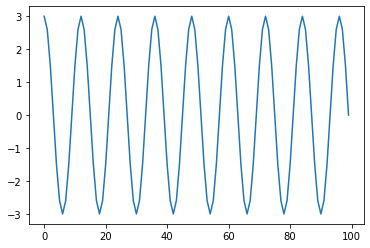

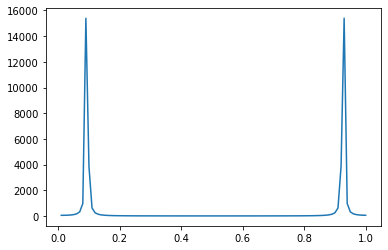

In [172]:
disp_burst(0)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


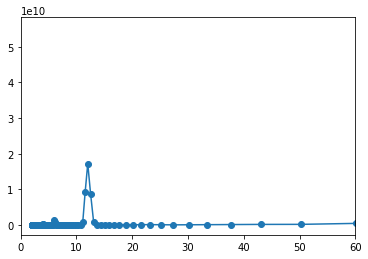

In [41]:
import numpy as np

fig = plt.figure()
for i, p in enumerate(parts_top.index[:1]):
    ax = fig.add_subplot(1,1,i+1)
    tmp = (df_warranty_part_num_monthly
           .loc[df_warranty_part_num_monthly.part_cd == p, ["month", "n"]])
    tmp = d.merge(tmp, on="month", how="left").fillna(0).set_index("month").sort_index()["n"]
    tmp = tmp
    tmp_v = tmp.values
    ps = np.abs(np.fft.fft(tmp_v))**2
    freqs = np.fft.fftfreq(tmp_v.size, 1)
    idx = np.argsort(freqs)
    plt.plot(1/freqs[idx], ps[idx], "o-")
    plt.xlim(0,60)

301


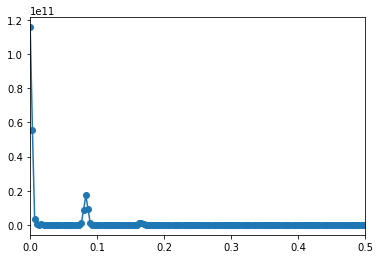

In [40]:
import numpy as np

fig = plt.figure()
for i, p in enumerate(parts_top.index[:1]):
    ax = fig.add_subplot(1,1,i+1)
    tmp = (df_warranty_part_num_monthly
           .loc[df_warranty_part_num_monthly.part_cd == p, ["month", "n"]])
    tmp = d.merge(tmp, on="month", how="left").fillna(0).set_index("month").sort_index()["n"]
    tmp = tmp
    tmp_v = tmp.values
    print(len(tmp_v))
    ps = np.abs(np.fft.fft(tmp_v))**2
    freqs = np.fft.fftfreq(tmp_v.size, 1)
    idx = np.argsort(freqs)
    plt.plot(freqs[idx], ps[idx], "o-")
    plt.xlim(0, 0.5)

## 経過月

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


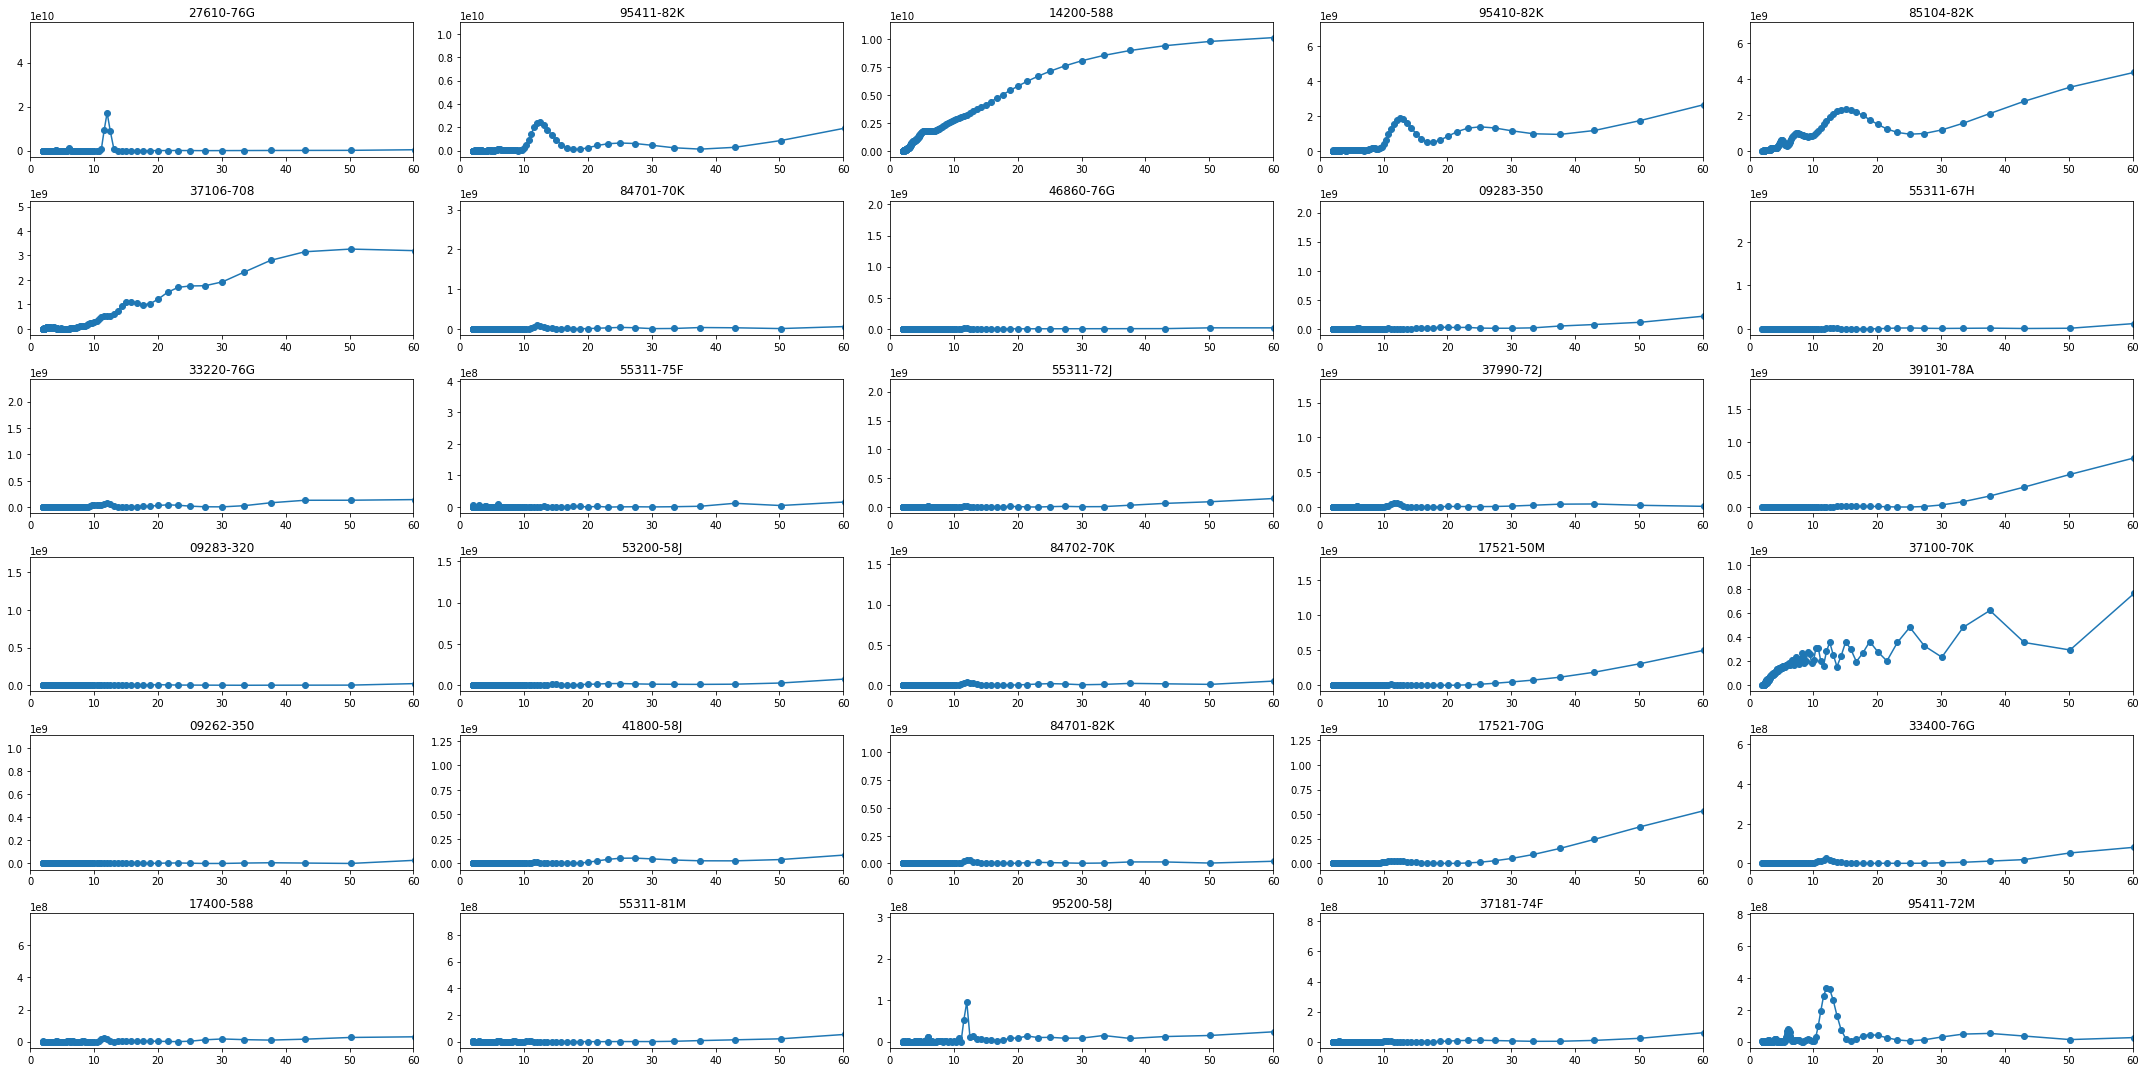

In [39]:
import numpy as np

fig = plt.figure(figsize=(30,15))
for i, p in enumerate(parts_top.index[:30]):
    ax = fig.add_subplot(6,5,i+1)
    tmp = (df_warranty_part_num_monthly
           .loc[df_warranty_part_num_monthly.part_cd == p, ["month", "n"]])
    tmp = d.merge(tmp, on="month", how="left").fillna(0).set_index("month").sort_index()["n"]
    tmp = tmp
    tmp_v = tmp.values
    ps = np.abs(np.fft.fft(tmp_v))**2
    freqs = np.fft.fftfreq(tmp_v.size, 1)
    idx = np.argsort(freqs)
    plt.plot(1/freqs[idx], ps[idx], "o-")
    plt.xlim(0,60)
    plt.title(p)

plt.tight_layout()

Text(0.5, 1.0, '95411-72M')

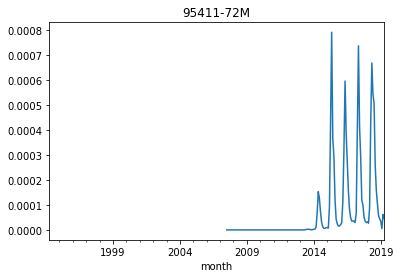

In [38]:
tmp.plot()
plt.title(p)

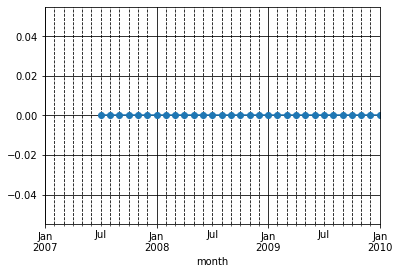

In [37]:
tmp.loc[datetime(2007,1,1):(datetime(2010,1,1))].plot(marker="o")
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='--')

## みせかけの相関

In [46]:
df_warranty_part_num_monthly_top30 = df_warranty_part_num_monthly.loc[
    df_warranty_part_num_monthly.part_cd.isin(parts_top.index[:30])
]

In [48]:
df_warranty_part_num_monthly_top30.head()

,part_cd,month,n
17422,53200-58J,2003-08-01,1
17423,53200-58J,2003-11-01,1
17424,53200-58J,2004-01-01,1
17442,53200-58J,2015-12-01,1
17443,53200-58J,2016-04-01,1


In [50]:
df_warranty_part_num_monthly_top30_pivot = (df_warranty_part_num_monthly_top30
                                            .pivot(index="month", columns="part_cd", values="n"))

In [52]:
df_warranty_part_num_monthly_top30_pivot.shape

(268, 30)

In [61]:
corr_spurious = df_warranty_part_num_monthly_top30_pivot.fillna(0).corr()

In [72]:
high_corr_pair = np.where(corr_spurious > 0.9)

high_corr_pair = [(i,j) for i,j in zip(high_corr_pair[0], high_corr_pair[1])
                 if i < j]

In [73]:
high_corr_pair

[(0, 1),
 (0, 12),
 (1, 12),
 (21, 22),
 (21, 23),
 (21, 24),
 (22, 23),
 (22, 24),
 (23, 24)]

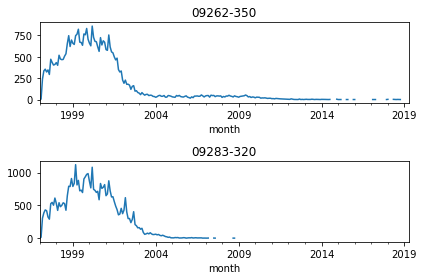

----------------------------------------------------------------------------------------------------


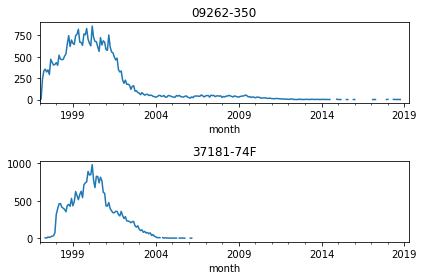

----------------------------------------------------------------------------------------------------


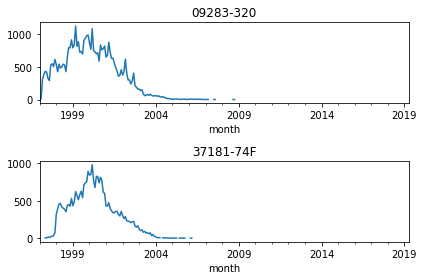

----------------------------------------------------------------------------------------------------


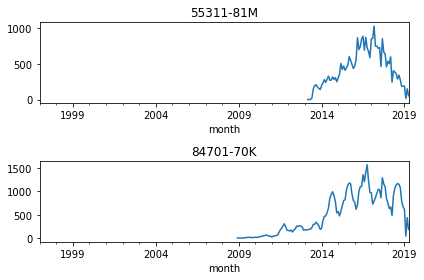

----------------------------------------------------------------------------------------------------


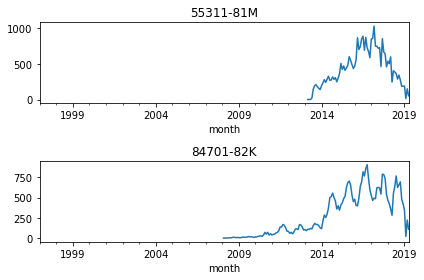

----------------------------------------------------------------------------------------------------


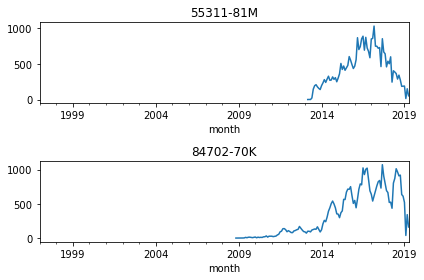

----------------------------------------------------------------------------------------------------


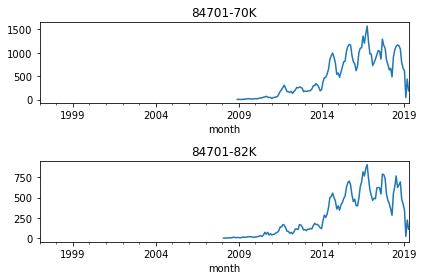

----------------------------------------------------------------------------------------------------


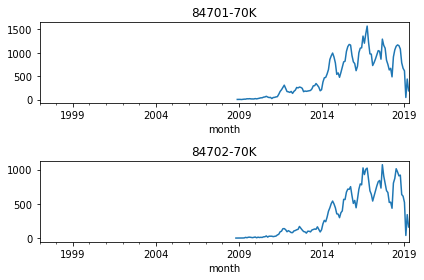

----------------------------------------------------------------------------------------------------


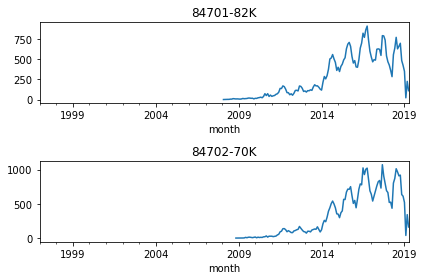

----------------------------------------------------------------------------------------------------


In [76]:
for i,j in high_corr_pair:
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,i].plot(ax=ax)
    ax.set_title(df_warranty_part_num_monthly_top30_pivot.columns[i])
    
    ax = fig.add_subplot(2,1,2)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,j].plot(ax=ax)
    ax.set_title(df_warranty_part_num_monthly_top30_pivot.columns[j])
    plt.tight_layout()
    plt.show()
    print("-"*100)

In [77]:
corr_diff = df_warranty_part_num_monthly_top30_pivot.fillna(0).diff().corr()

In [78]:
high_corr_pair_diff = np.where(corr_diff > 0.9)

high_corr_pair_diff = [(i,j) for i,j in zip(high_corr_pair_diff[0], high_corr_pair_diff[1])
                 if i < j]

In [80]:
high_corr_pair_diff

[(22, 23), (22, 24)]

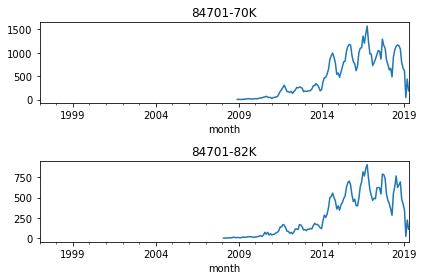

----------------------------------------------------------------------------------------------------


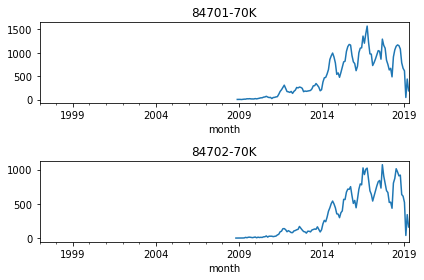

----------------------------------------------------------------------------------------------------


In [81]:
for i,j in high_corr_pair_diff:
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,i].plot(ax=ax)
    ax.set_title(df_warranty_part_num_monthly_top30_pivot.columns[i])
    
    ax = fig.add_subplot(2,1,2)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,j].plot(ax=ax)
    ax.set_title(df_warranty_part_num_monthly_top30_pivot.columns[j])
    plt.tight_layout()
    plt.show()
    print("-" * 100)

In [82]:
np.random.randn(20)

array([-0.90890197,  1.59818315,  0.21496547, -0.67808486, -0.93375648,
        0.69780462, -0.72648589, -1.45291126, -0.67961291,  0.3521036 ,
        0.02589738,  0.08577688, -1.37714041,  0.16675832,  1.76972152,
       -1.14439775,  0.41325424, -2.47170106,  0.50450206, -1.28951304])

In [88]:
list(range(30))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [92]:
df_30_random_s = pd.DataFrame({"val" + str(i): np.random.randn(300) for i in range(30)}).cumsum()

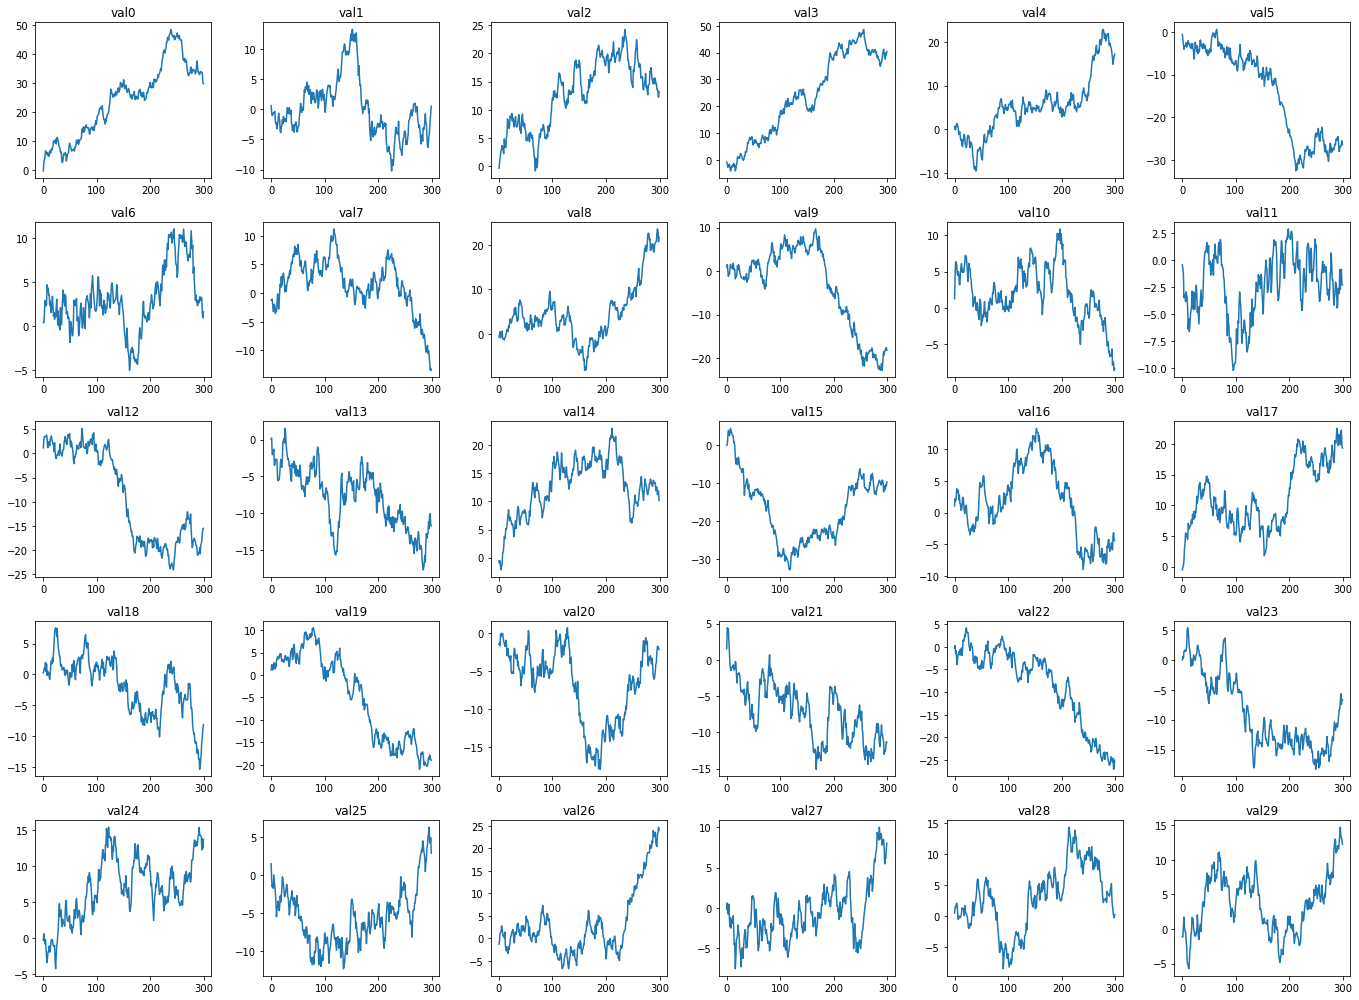

In [101]:
fig = plt.figure(figsize=(19,14))
for i, (v, s) in enumerate(df_30_random_s.iteritems()):
    ax = fig.add_subplot(5,6,i+1)
    ax.plot(s)
    ax.set_title(v)

plt.tight_layout()

In [103]:
corr_rand = df_30_random_s.corr()
corr_rand_diff = df_30_random_s.diff().corr()

high_corr_rand = np.where(corr_rand > 0.9)
high_corr_rand = [(i,j) for i,j in zip(high_corr_rand[0], high_corr_rand[1])
                 if i < j]

high_corr_rand_diff = np.where(corr_rand_diff > 0.9)
high_corr_rand_diff = [(i,j) for i,j in zip(high_corr_rand_diff[0], high_corr_rand_diff[1])
                 if i < j]

In [107]:
print(high_corr_rand)

[(0, 3), (5, 19), (12, 19)]


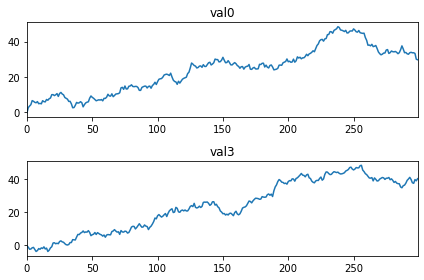

----------------------------------------------------------------------------------------------------


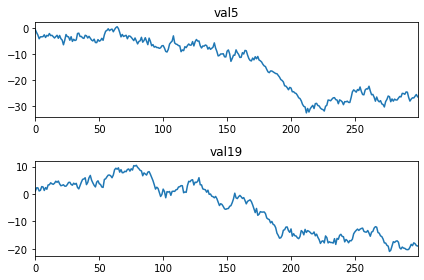

----------------------------------------------------------------------------------------------------


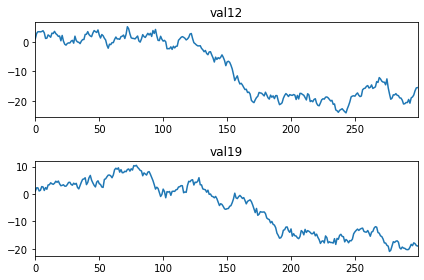

----------------------------------------------------------------------------------------------------


In [108]:
for i,j in high_corr_rand:
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    df_30_random_s.iloc[:,i].plot(ax=ax)
    ax.set_title(df_30_random_s.columns[i])
    
    ax = fig.add_subplot(2,1,2)
    df_30_random_s.iloc[:,j].plot(ax=ax)
    ax.set_title(df_30_random_s.columns[j])
    plt.tight_layout()
    plt.show()
    print("-" * 100)

In [106]:
high_corr_rand_diff

[]

## (略)DTW

In [110]:
from fastdtw import fastdtw

In [122]:
n

268

In [136]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm import tnrange, tqdm_notebook

tmp = df_warranty_part_num_monthly_top30_pivot.fillna(0)
n = tmp.shape[1]
distance_m = np.zeros((n, n))
for i in tnrange(n):
    for k in range(i):
        distance, path = fastdtw(df_warranty_part_num_monthly_top30_pivot.iloc[:,i].fillna(0),
                         df_warranty_part_num_monthly_top30_pivot.iloc[:,k].fillna(0), 
                         dist=euclidean)
        distance_m[i, k] = distance

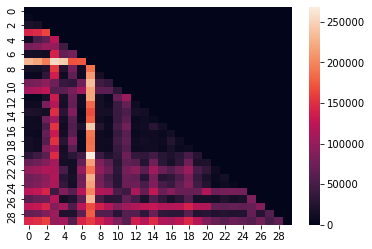

In [137]:
import seaborn as sns

sns.heatmap(distance_m)

In [138]:
distance_m[:,0]

array([     0.,   5530.,  20128., 143581.,  11816.,  81587.,  16249.,
       229265.,  16123.,   7872.,  78862., 108631.,   4190.,  10788.,
        20122.,  10196.,   9959.,   8706.,  14975.,  13423.,  30752.,
        70682.,  99108.,  74539.,  80248., 122165.,  61308., 123990.,
        67865., 145213.])

In [144]:
np.argsort(distance_m[:,0])

array([ 0, 12,  1,  9, 17, 16, 15, 13,  4, 19, 18,  8,  6, 14,  2, 20, 26,
       28, 21, 23, 10, 24,  5, 22, 11, 25, 27,  3, 29,  7])

### 先行指標?

## (略)時系列予測(ローカル, トレンド, 周期性モデル)

### (略)ベンチマーク

### (略)時系列予測

question 1: 何が効く?
    - ?生産台数(採用機種数 x 機種生産台数)
    - ?生産月
    - ?FTIRとその対策
    - ?季節性
    - ?出荷地域
    - ?経過期間

question 2:なぜローカル, トレンド, 周期性なのか
    - ローカル: 似たような値が続く
        - ?生産台数は急激に変わらない
    - トレンド: 上昇・下降は続く
        - ?生産台数の拡大が続く
        - ?FTIRの対策による減少傾向
    - 周期性: 
        - ?季節の寒暖差
        - ?利用のシーズン差

question 3:では、どのようなデータがあれば良いか